# 1. SHAP values ✨

Shap value helps us quantify feature’s contribution towards a prediction. Shap value closer to zero means the feature contributes little to the prediction whereas shap value away from zero indicates the feature contributes more.

In [1]:
# Imports
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{:.4f}".format(x)})
import pandas as pd
pd.options.display.float_format = "{:.3f}".format
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='rainbow')
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import shap
shap.initjs()

In [2]:
# Import sample data
diabetes = load_diabetes(as_frame=True)
X = diabetes['data'].iloc[:, :4] # Select first 4 columns
y = diabetes['target']

In [3]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}\n")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")
display(X_train.head())

Training features shape: (353, 4)
Training target shape: (353,)

Test features shape: (89, 4)
Test target shape: (89,)


,age,sex,bmi,bp
438,-0.006,0.051,-0.016,-0.068
232,0.013,0.051,0.000,-0.011
80,0.071,-0.045,0.012,0.043
46,-0.056,-0.045,-0.012,-0.033
381,-0.071,0.051,-0.089,-0.075


In [4]:
# Train a simple model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

One common way to get shap values is to use the Explainer object. Let’s create an `Explainer` object and extract `shap_test` for the test data:

In [5]:
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

Shap values length: 89

Sample shap value:
.values =
array([-1.7529, 2.0813, -24.6496, -25.6341])

.base_values =
array([153.4353])

.data =
array([0.0417, -0.0446, -0.0321, -0.0619])


The length of `shap_test` is 89 because it contains a record for each test instance. From looking at the first test record, we can see that there are three attributes:

- `shap_test[0].values`: Shap value for each feature
- `shap_test[0].base_values`: Base value for target
- `shap_test[0].data`: Value for each feature

## 📍 1.1 Base values

Base value (`shap_test.base_values`), also known as the *expected value* (`explainer.expected_value`), is the *average target value* in the training data. We can check this with the following code:

In [6]:
print(f"Expected value: {explainer.expected_value[0]:.1f}")
print(f"Average target value (training data): {y_train.mean():.1f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.1f}")

Expected value: 153.4
Average target value (training data): 153.4
Base value: 153.4


Hence, we will use the word expected value and base value interchangeably.

## 📦 1.2. Data

Next, `shap_test.data` contains the same values as `X_test`:

In [7]:
(shap_test.data == X_test).describe()

,age,sex,bmi,bp
count,89,89,89,89
unique,1,1,1,1
top,True,True,True,True
freq,89,89,89,89


In [8]:
X_test

,age,sex,bmi,bp
246,0.042,-0.045,-0.032,-0.062
425,-0.078,-0.045,-0.041,-0.081
293,-0.071,-0.045,0.093,0.013
31,-0.024,-0.045,-0.065,-0.081
359,0.038,0.051,0.006,0.032
...,...,...,...,...
277,-0.035,-0.045,-0.059,0.001
132,0.016,0.051,-0.021,-0.009
213,0.002,-0.045,-0.071,-0.023
286,-0.038,-0.045,-0.055,-0.078


Let’s convert it to a DataFrame and have a look:

In [9]:
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, 
             index=X_test.index)

,age,sex,bmi,bp
246,0.042,-0.045,-0.032,-0.062
425,-0.078,-0.045,-0.041,-0.081
293,-0.071,-0.045,0.093,0.013
31,-0.024,-0.045,-0.065,-0.081
359,0.038,0.051,0.006,0.032
...,...,...,...,...
277,-0.035,-0.045,-0.059,0.001
132,0.016,0.051,-0.021,-0.009
213,0.002,-0.045,-0.071,-0.023
286,-0.038,-0.045,-0.055,-0.078


So, it’s just a copy of the dataset we passed on to.

## ✨ 1.3. Values

The most important attribute from `shap_test` is the `values` attribute. This is because we can access the shap values from it. Let’s convert the shap values into a DataFrame for easier manipulation:

In [10]:
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

,age,sex,bmi,bp
246,-1.753,2.081,-24.650,-25.634
425,5.925,3.863,-33.091,-12.753
293,-14.266,-0.535,75.543,-11.028
31,-8.554,2.101,-39.069,-23.174
359,9.539,0.213,-7.332,8.434
...,...,...,...,...
277,-10.023,3.528,-45.031,-8.440
132,-4.953,-5.497,-35.544,2.948
213,-6.329,2.796,-53.651,-11.681
286,-4.718,2.903,-45.648,-21.633


We can see the shap values by feature for each record. If we add these shap values to the expected value, we will get the prediction:

<img src = "pics/shap_prediction.png" width=600 height=100 />

Let’s check if this is the case:

In [11]:
np.isclose(model.predict(X_test), 
           explainer.expected_value[0] + shap_df.sum(axis=1))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

Now, we have the shap values, we can do custom visualisations like this one to understand the feature contribution:

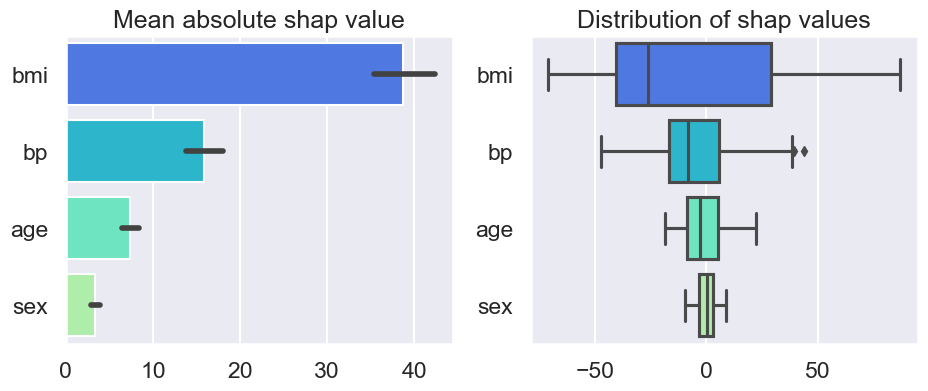

In [12]:
columns = (shap_df
           .apply(np.abs)
           .mean()
           .sort_values(ascending=False)
           .index
          )
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
sns.barplot(
    data=shap_df[columns].apply(np.abs), orient='h', ax=ax[0]
)
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

The left subplot shows the mean absolute shap value for each feature whereas the right subplot shows the distribution of the shap values by feature. One takeaway from these graphs is that `bmi` has the biggest contribution among the 4 features being used.

# 2. Shap built-in plots 📊

We are going to look at two main kinds of plots:

🌳 **Global**: Plots visualising feature’s overall contribution. This kind of plot shows an aggregated contribution of a feature over the entire data.

🍀 **Local**: Plots showing feature’s contribution in a particular instance. This helps us drill down into individual predictions.

## 🌳 2.1. Global | Bar plot

For the left subplot shown earlier, there’s an equivalent built-in function which takes only a few keystrokes:

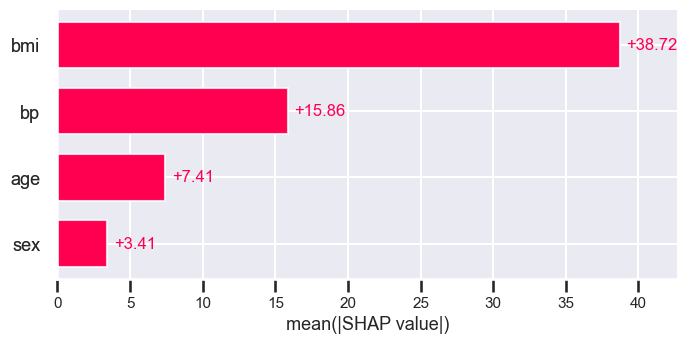

In [13]:
shap.plots.bar(shap_test)

This simple but useful plot shows the strength of features’ contribution. The plot is based on the mean absolute shap values by features: `shap_df.apply(np.abs).mean()`. Features are ranked from top to bottom where feature with the highest average absolute shap value is shown at the top.

## 🌳 2.2. Global | Summary plot

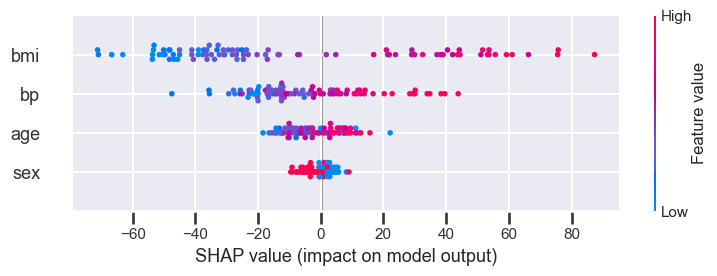

In [14]:
shap.summary_plot(shap_test)

Here’s an alternative syntax: `shap.plots.beeswarm(shap_test)` for this exact plot. Just like before, features are sorted by their mean absolute shap value. This chart is more complicated and packed with more information compared to the previous bar plot. Here’s a guide to interpret this plot:

- Horizontal axis of the plot shows the shap value distribution of a feature. Each dot represents a record in the dataset. For instance, we can see that for `bmi`, dots are quite scattered and there are barely any dots around 0 whereas dots are clustered closer to 0 for `age`.

- The colour of dots shows the feature values. This addition dimension allows us to see the how the shap values changes as the feature value changes. In other words, we can see the direction of the relationship. For instance, we can see that shap value tend to be higher when `bmi` is high (represented by hot pink dots) and lower when `bmi` is low (represented by blue dots). There are also some purple points scattered across the spectrum as well.

If we find the default colourmap to be not intuitive or not suitable, we can change it to our preferred **matplotlib colourmap** like this:

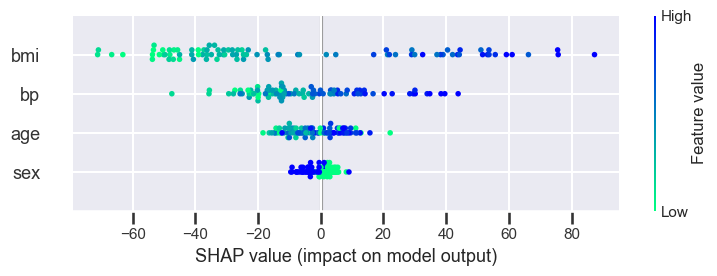

In [15]:
shap.summary_plot(shap_test, cmap=plt.get_cmap("winter_r"))

In addition, there are different plot types we can use. Here’s an example:

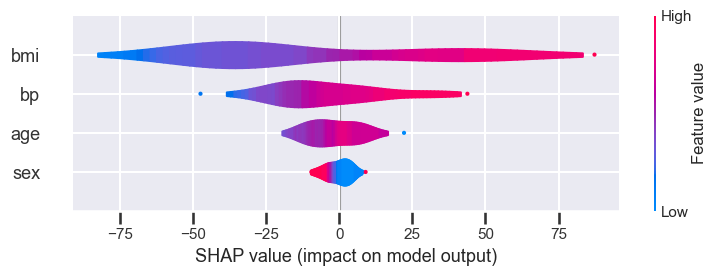

In [16]:
shap.summary_plot(shap_test, plot_type='violin')

## 🌳 2.3. Global | Heatmap

Heatmap is another way to visualise the shap values. Instead of aggregating shap value to a mean, we see colour-coded individual values. Features are plotted on y-axis and records are plotted on x-axis:

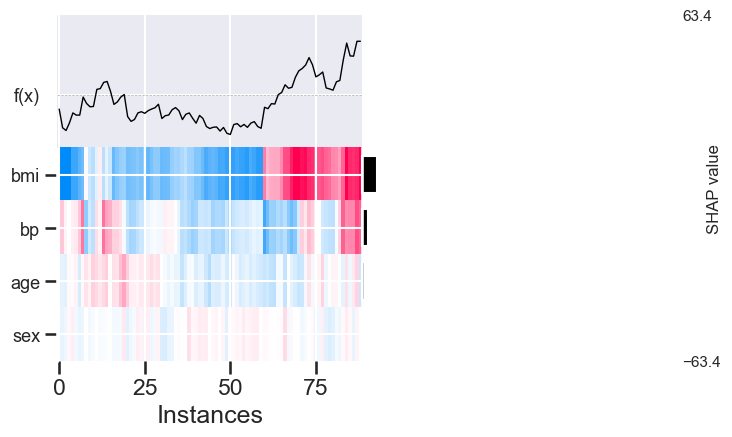

In [17]:
shap.plots.heatmap(shap_test)

This heatmap is supplemented by a line plot of the predicted value (i.e. `f(x)`) for each record at the top.

We can change the colourmap to our desired one with the `cmap` parameter:

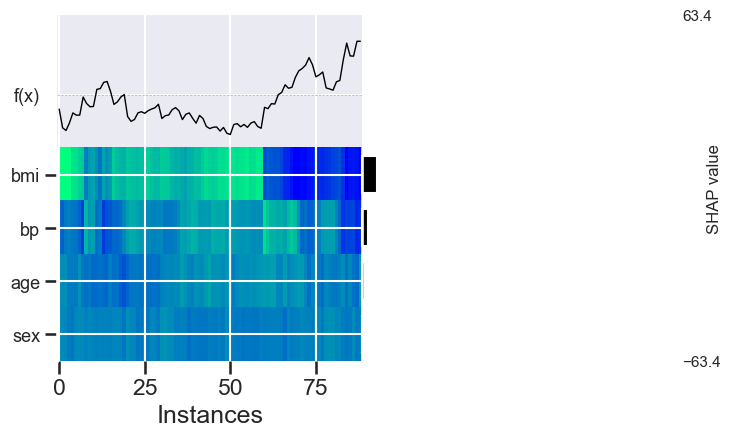

In [18]:
shap.plots.heatmap(shap_test, cmap=plt.get_cmap("winter_r"))

## 🌳 2.4. Global | Force plot

This interactive plot allows us to see shap value make-up by record:

In [19]:
shap.force_plot(explainer.expected_value, shap_test.values, X_test)

Just like heatmap, x-axis shows each record. Positive shap values are shown in red and and negative ones are in blue. For instance, since the first record had more red contributions than blue ones, the prediction for this record would be higher than the expected value.

The interactivity allows us to change both axes. For instance, y-axis shows predictions, `f(x)` and x-axis is sorted by the output (prediction) value in the snapshot above.

## 🍀 2.5. Local | Bar plot

Now we will look at plots for understanding predictions for individual cases. Let’s start with a bar plot:

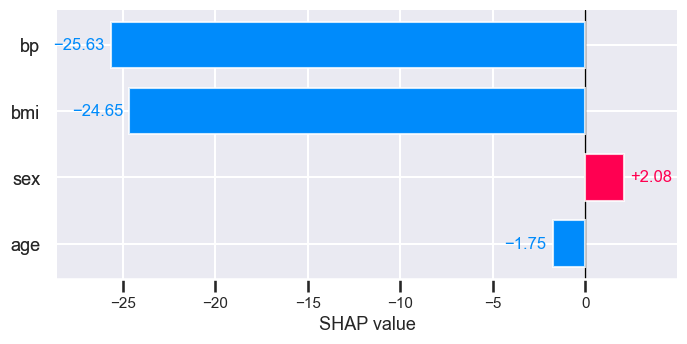

In [20]:
shap.plots.bar(shap_test[0])

The syntax is exactly same as in section ‘2.1. Global | Bar plot’ except this time we sliced the data for a single record.

## 🍀 2.6. Local | Waterfall plot

This is another alternative to the bar plot:

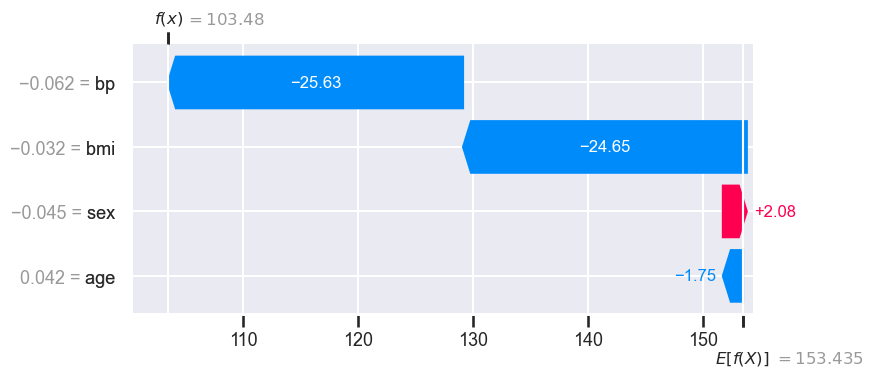

In [21]:
class WaterfallData():
    def __init__(self, shap_test, index):
        self.values = shap_test[index].values
        self.base_values = shap_test[index].base_values[0]
        self.data = shap_test[index].data
        self.feature_names = shap_test.feature_names
        self.display_data = None  # I added this

shap.plots.waterfall(WaterfallData(shap_test, 0))

The waterfall plot is information-dense and there are four bits of information:

- On the y-axis, we see the actual feature value for the record. If you are not sure what I mean, compare `X_test.head(1)` to the values on the y-axis.

- At the bottom right corner of the chart, we see `E[f(X)]`, the expected value.

- At the top left corner, we see `f(x)`, the predicted value.

- ️Just like the previous bar plot, horizontal bars represent the colour-coded feature contribution. Starting from the expected value at the bottom, we can see how each contribution is moving the prediction up and down to finally arrive at the predicted value.

## 🍀 2.7. Local | Force plot

Last plot to familiarise is the force plot for a single record. If we rotate this plot 90 degrees and plot it for multiple records, we will see the global force plot.

In [22]:
shap.plots.force(shap_test[0])

We can see both the base value:153.4 and the prediction: 103.48. We can also see the breakdown of the feature contributions.